# CAMELS-DE Dataset Metrics

This notebook should be run, after the dataset has been processed, or changes have been made to the processing.
It will generate a number of metrics for the dataset and store plotly JSONs for the Metrics API

In [38]:
from camelsp import Bundesland, util
import plotly.graph_objects as go 
from tqdm import tqdm
import json
import numpy as np
from collections import defaultdict

## Main loop

Run over all datasets and calculate some stuff

In [128]:
# container for a flag tree
ids = ["CAMELS-DE"]
labels = ["CAMELS-DE"]
parents = [""]
values = [0]
all_ = 0

file_exists = []    # count existing trees
file_nuts = []      # count label for nuts

# load all metadata 
metadata = util.get_metadata()

for NUTS in util._NUTS_LVL2_NAMES.keys():
    with Bundesland(NUTS) as bl:
        meta = bl.metadata

        # container to count flags
        w = defaultdict(lambda: 0)
        q = defaultdict(lambda: 0)

        # load all datasets
        for camels_id in tqdm(meta.camels_id.values):
            try:
                df = bl.get_data(camels_id)
                file_exists.append(True)
            except Exception as e:
                file_exists.append(False)
                continue
            # add the label for the exists flag
            file_nuts.append(NUTS)
            
            # calculate for w
            if 'w_flag' in df:
                w['NaN'] += df.w_flag.isna().sum()
                w['checked'] += df.w_flag.dropna().sum()
                w['not checked'] += (~(df.w_flag.dropna().astype(bool))).sum()

            # calculate for q
            if 'q_flag' in df:
                q['NaN'] += df.q_flag.isna().sum()
                q['checked'] += df.q_flag.dropna().sum()
                q['not checked'] += (~(df.q_flag.dropna().astype(bool))).sum()

        # ad to container
        name = util._NUTS_LVL2_NAMES[NUTS]

        # first level + second level
        tot_q = sum(list(q.values()))
        tot_w = sum(list(w.values()))
        labels.extend([name, 'discharge', 'waterlevel'])
        ids.extend([name, f'{name}-q', f'{name}-w'])
        parents.extend(['CAMELS-DE', name, name])
        values.extend([tot_q + tot_w, tot_q, tot_w])

        # add third level
        for stat, short in zip([q, w], ['q', 'w']):
            for key, count in stat.items():
                labels.append(key)
                ids.append(f'{name}-{short}-{key}')
                parents.append(f'{name}-{short}')
                values.append(count)

        all_ += tot_q + tot_w

# the the overall measurements
values[0] = all_


100%|██████████| 540/540 [00:08<00:00, 67.32it/s]
0it [00:00, ?it/s]
100%|██████████| 382/382 [00:04<00:00, 95.07it/s] 
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 437/437 [00:03<00:00, 109.77it/s]
0it [00:00, ?it/s]
100%|██████████| 63/63 [00:01<00:00, 54.22it/s]


## Sunburst

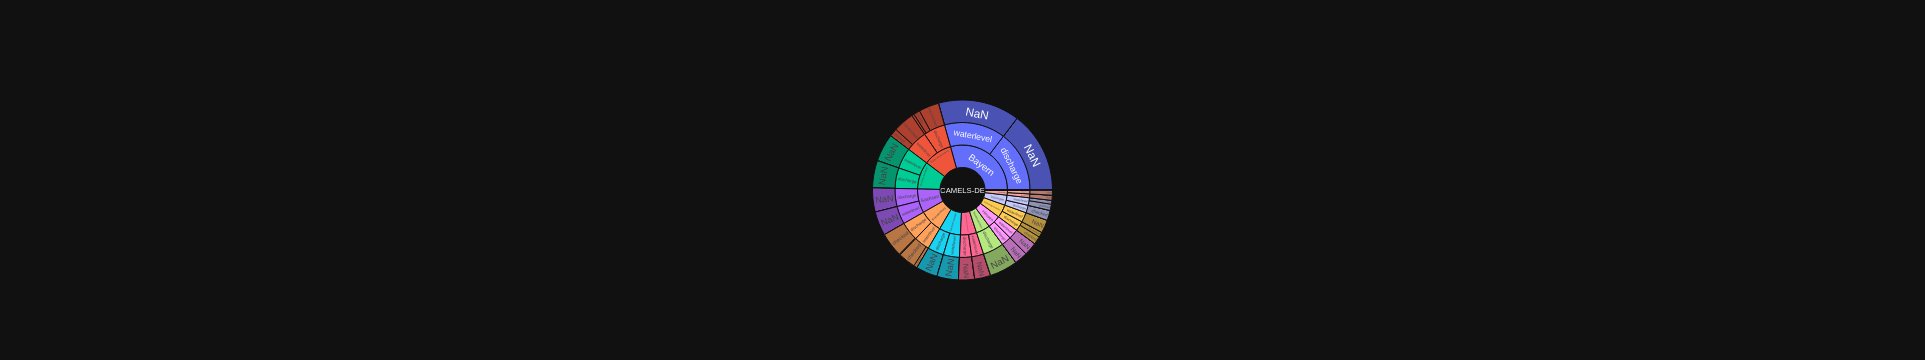

In [125]:
fig = go.Figure(go.Sunburst(
    ids=ids,
    labels=labels, 
    parents=parents, 
    values=values, 
    branchvalues="total",
    hoverinfo="label+percent parent+percent root+value"
))
fig.update_layout(template='plotly_dark')
fig

In [126]:
with open('../output_data/metrics/flags.plotly.json', 'w') as f:
    f.write(fig.to_json())

# add description
with open('../output_data/metrics/flags.description.json', 'w') as f:
    json.dump({
        'title': 'CAMELS-DE quality flags',
        'body': 'The sunburst shows the number of quality flags available on three levels. The first level discriminates by federal state.By clicking on a state, you can filter for this state only. The second level breaks the number of flags measured in that state further down by variable and the third level by the flag. Currently, flags can be True (checked), False (not checked) or NaN if there is no flag information or the measurements are missing',
        'actions': [{'href': 'https://github.com/CAMELS-DE/camelsp/blob/main/scripts/dataset_metrics.ipynb', 'title': 'Resource on Github'}]
    }, f)


## Number of Stations

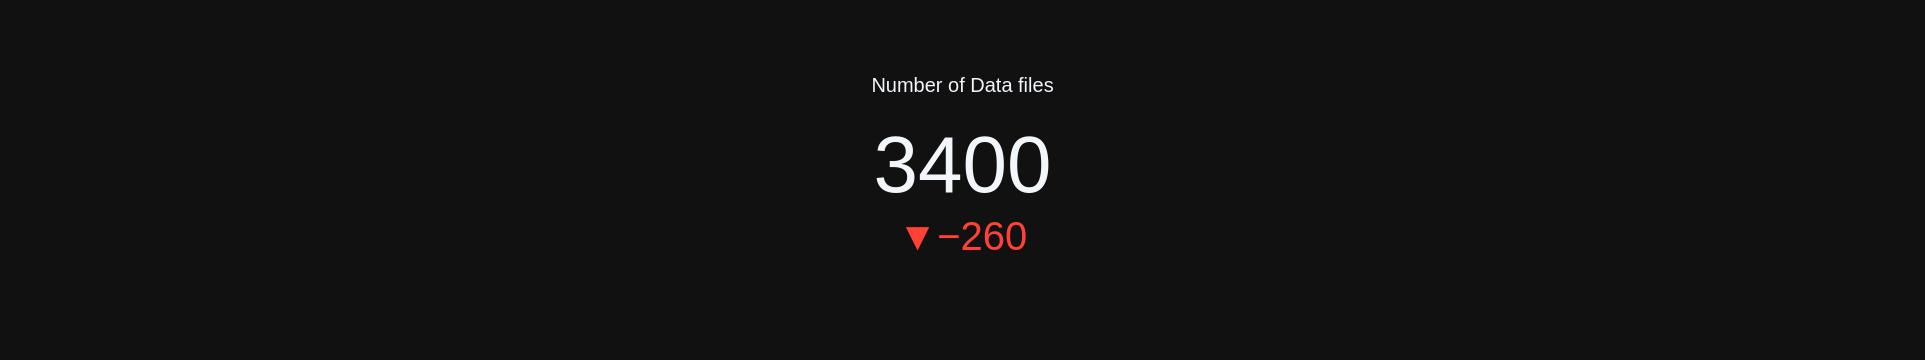

In [132]:
fig = go.Figure(go.Indicator(
    value=sum(file_exists),
    mode="number+delta",
    title="Number of Data files",
    delta=dict(reference=len(metadata))
))
fig.update_layout(template='plotly_dark')
fig

In [134]:
with open('../output_data/metrics/count.plotly.json', 'w') as f:
    f.write(fig.to_json())

# add description
with open('../output_data/metrics/count.description.json', 'w') as f:
    json.dump({
        'title': 'CAMELS-DE data files',
        'body': 'This is the current amount of CAMELS-DE data files, that have been processed. The delta indicator shows the difference to the size of the Metadata table. A negative number indicates, that there are discharge stations for which either no data was provided at all, or the processing failed alltogether.',
        'actions': [{'href': 'https://github.com/CAMELS-DE/camelsp/blob/main/scripts/dataset_metrics.ipynb', 'title': 'Resource on Github'}]
    }, f)

## Existing data files

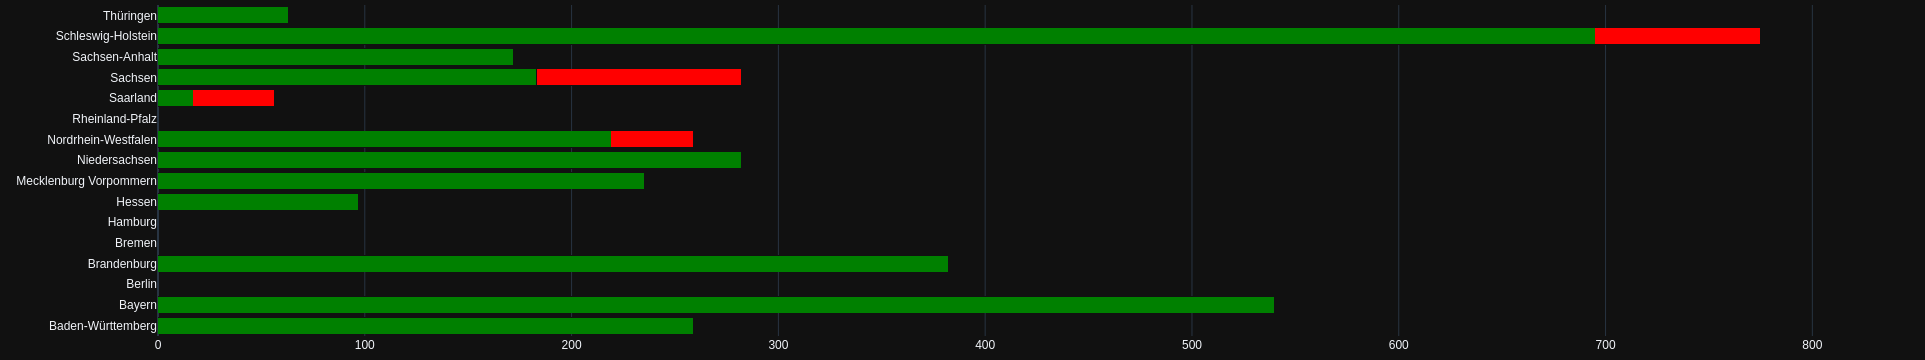

In [140]:
fig = go.Figure()

for NUTS in util._NUTS_LVL2_NAMES.keys():
    # filter 
    exist = [b for b, label in zip(file_exists, file_nuts) if label==NUTS]
    name = util._NUTS_LVL2_NAMES[NUTS]

    # add traces
    fig.add_trace(go.Bar(x=[sum(exist)], y=[name], orientation='h', marker=dict(color='green'), name='existing files', showlegend=False))
    fig.add_trace(go.Bar(x=[len(exist) - sum(exist)], y=[name], orientation='h', marker=dict(color='red'), name="missing files", showlegend=False))

fig.update_layout(barmode="stack", template='plotly_dark', margin=dict(t=5, b=15))
fig

In [142]:
with open('../output_data/metrics/states_count.plotly.json', 'w') as f:
    f.write(fig.to_json())

# add description
with open('../output_data/metrics/states_count.description.json', 'w') as f:
    json.dump({
        'title': 'Data files per state',
        'body': 'The bars show the amount of CAMELS-DE data files, that have been processed. THe green bars show how many data files have been processed, the red bar indicates the number of missing files. Files are missing for discharge stations, if either no data was provided at all, or the processing failed alltogether.',
        'actions': [{'href': 'https://github.com/CAMELS-DE/camelsp/blob/main/scripts/dataset_metrics.ipynb', 'title': 'Resource on Github'}]
    }, f)